In [1]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# For graphs
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import os

In [2]:
df = pd.read_csv("AAPL.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600
...,...,...,...,...,...,...,...
10404,2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200
10405,2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400
10406,2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000
10407,2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10409 non-null  object 
 1   Open       10409 non-null  float64
 2   High       10409 non-null  float64
 3   Low        10409 non-null  float64
 4   Close      10409 non-null  float64
 5   Adj Close  10409 non-null  float64
 6   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 569.4+ KB


In [4]:
df.describe().T.apply(lambda x: x.apply("{0:.3f}".format))

,count,mean,std,min,25%,50%,75%,max
Open,10409.000,13.960,30.169,0.050,0.282,0.469,14.218,182.630
High,10409.000,14.112,30.515,0.050,0.288,0.478,14.364,182.940
Low,10409.000,13.809,29.835,0.049,0.275,0.460,14.044,179.120
Close,10409.000,13.967,30.192,0.049,0.281,0.469,14.206,182.010
Adj Close,10409.000,13.350,29.911,0.038,0.235,0.387,12.188,181.778
Volume,10409.000,332177847.171,339334418.573,0.000,124760400.000,219968000.000,412610800.000,7421640800.000


In [5]:
df["Date"] = pd.to_datetime(df["Date"])


In [7]:
df = df.set_index("Date")
fig = make_subplots(rows=6, cols=1,
                    subplot_titles=("Opening Price", "Closing Price", "Highest Price",
                                    "Lowest Price", "Adjusted Closing Price", "Volume"))

fig.add_trace(go.Scatter(x=df.index, y=df["Open"]), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["Close"]), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["High"]), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["Low"]), row=4, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["Adj Close"]), row=5, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df["Volume"]), row=6, col=1)
fig.update_layout(showlegend=False, height=1200, width=800)
fig.show()

In [8]:
df_last_10_years = df['2014-01-01':'2023-12-31']

fig = go.Figure(data=go.Ohlc(x=df_last_10_years.index,
                             open=df_last_10_years["Open"],
                             high=df_last_10_years["High"],
                             low=df_last_10_years["Low"],
                             close=df_last_10_years["Close"]))

fig.update_layout(
    title="OHLC Chart for Apple (2014-2023)",
    title_x=0.5,
    xaxis_rangeslider_visible=False
)

fig.show()

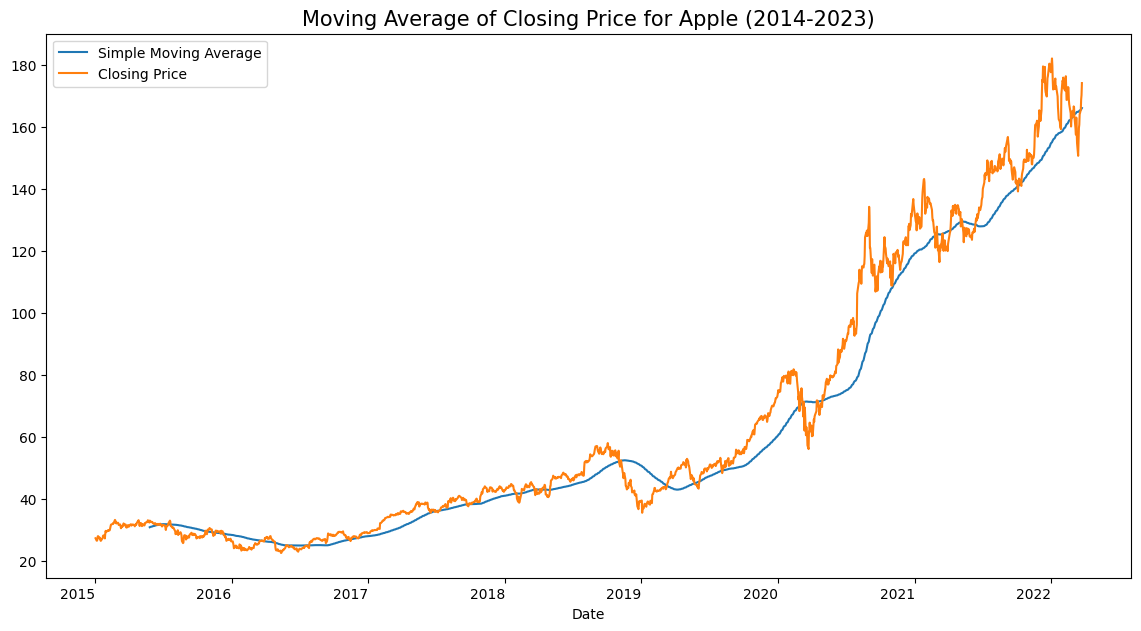

In [9]:
df_last_10_years = df['2015-01-01':'2023-12-31']

# Calculate Simple Moving Average
simple_ma = df_last_10_years["Close"].rolling(window=100).mean()

# Plotting
plt.figure(figsize=(14,8))
simple_ma.plot(label="Simple Moving Average")
df_last_10_years["Close"].plot(label="Closing Price")
plt.xticks(rotation=0)
plt.title("Moving Average of Closing Price for Apple (2014-2023)", size=15)
plt.legend()
plt.show()

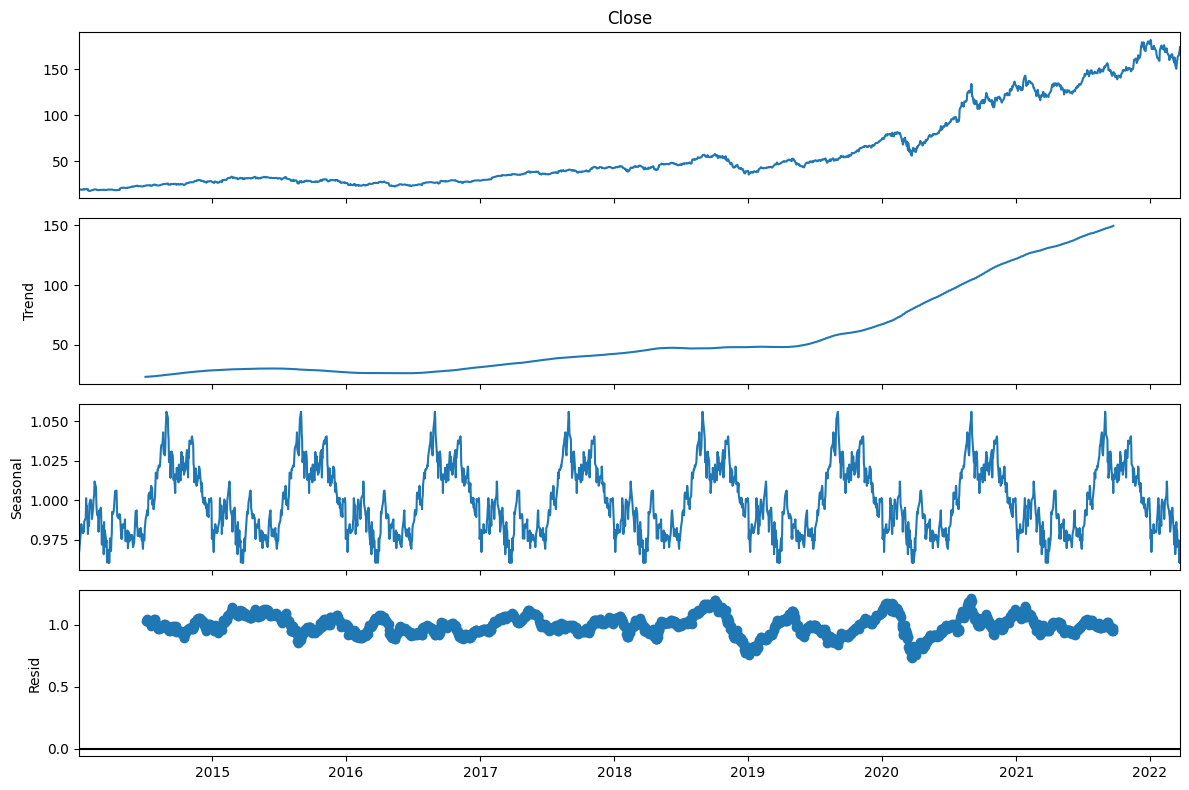

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_last_10_years = df['2014-01-01':'2023-12-31']

results = seasonal_decompose(df_last_10_years["Close"], model="multiplicative", period=252)

fig = results.plot()
fig.set_size_inches(12, 8)
fig.tight_layout()
plt.show()

In [11]:
trainData = df.iloc[:, 1:2].values
trainData.shape

(10409, 1)

In [12]:
scaler = MinMaxScaler()
trainData = scaler.fit_transform(trainData)
trainData

array([[4.33270567e-04],
       [3.96658463e-04],
       [3.47836857e-04],
       ...,
       [9.26075898e-01],
       [9.43682082e-01],
       [9.51883718e-01]])

In [13]:
X_train = []
y_train = []

for i in range(60, 10409):
    X_train.append(trainData[i-60:i, 0])
    y_train.append(trainData[i, 0])


X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(10349, 60)
(10349,)


In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(10349, 60, 1)

In [15]:
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [16]:
hist = model.fit(X_train, y_train, epochs = 7, batch_size = 64, verbose = 2)


Epoch 1/7
162/162 - 72s - loss: 0.0015 - 72s/epoch - 444ms/step
Epoch 2/7
162/162 - 58s - loss: 4.4758e-04 - 58s/epoch - 358ms/step
Epoch 3/7
162/162 - 57s - loss: 3.7958e-04 - 57s/epoch - 352ms/step
Epoch 4/7
162/162 - 58s - loss: 3.7060e-04 - 58s/epoch - 355ms/step
Epoch 5/7
162/162 - 57s - loss: 2.8803e-04 - 57s/epoch - 350ms/step
Epoch 6/7
162/162 - 56s - loss: 3.1658e-04 - 56s/epoch - 349ms/step
Epoch 7/7
162/162 - 59s - loss: 3.8630e-04 - 59s/epoch - 366ms/step


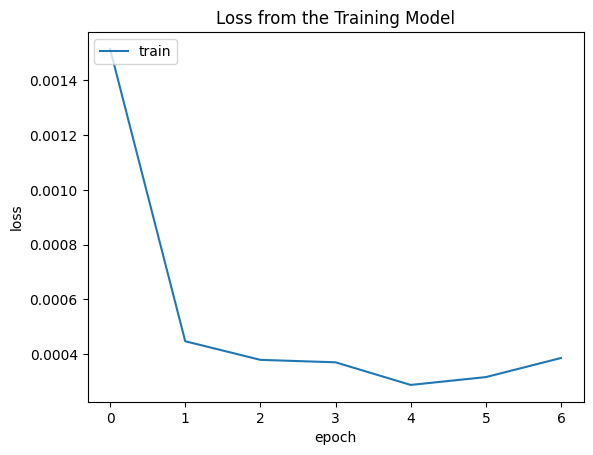

In [17]:
plt.plot(hist.history['loss'])
plt.title('Loss from the Training Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [18]:
testData = pd.read_csv("AAPL.csv")
testData['Open'] = pd.to_numeric(testData.Open, errors = 'coerce')
testData = testData.dropna()
testData = testData.iloc[:, 1:2]
y_test = testData.iloc[60:, 0:].values

inputOpen = testData.iloc[:, 0:].values
inputOpen_scaled = scaler.transform(inputOpen)
inputOpen_scaled.shape

X_test = []
length = len(testData)
timestep = 60
for i in range(timestep, length):
    X_test.append(inputOpen_scaled[i-timestep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(10349, 60, 1)

In [19]:
y_pred = model.predict(X_test)


324/324 [==============================] - 20s 58ms/step


In [ ]:
predicted_price = scaler.inverse_transform(y_pred)


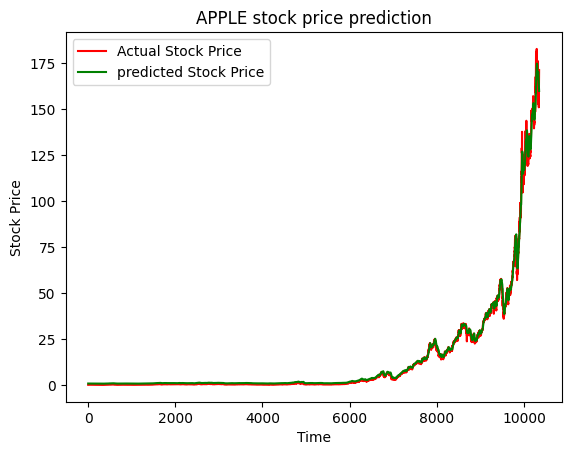

In [22]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'predicted Stock Price')
plt.title('APPLE stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error
import math

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, predicted_price))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1.6322300832616574
